In [1]:
### Reading all the libraries
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import copy
from sklearn.metrics import silhouette_score
# !pip install deepdiff
from deepdiff import DeepDiff
from sklearn.metrics import pairwise_distances
# !pip install validclust
from validclust import dunn
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D
import matplotlib.pyplot as plt
import logging
tf.random.set_seed(2)
tf.autograph.set_verbosity(0)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

### Reading Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
y_train.shape

(50000, 1)

### Converting the images to grayscale 

In [4]:
X_train = list(map(lambda x: tf.image.rgb_to_grayscale(x),X_train))
X_test = list(map(lambda x: tf.image.rgb_to_grayscale(x),X_test))

In [5]:
X_train_copy = np.array(copy.deepcopy(X_train))
X_test_copy = np.array(copy.deepcopy(X_test))

In [6]:
### Reshaping the images into 1024 features
X_train = np.reshape(X_train,(50000,1024))
X_test = np.reshape(X_test,(10000,1024))

In [7]:
### Changing the datatype of the stored values
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [8]:
### Scaling all the images by 255 pixel value so every value comes in the range of 0 to 1
X_train = X_train / 255.0 
X_test = X_test / 255.0

## KMeans

In [9]:
### Defining a class for kmeans which takes in training data, label and has parameters no_cluster and max_iterations
class Kmeans():
### Defining the init function which will assign values to variables defined during class call
    def __init__(self,train_data,label,no_clusters=10,max_iterations=1000):
        self.no_clusters = no_clusters
        self.max_iterations = max_iterations
        self.loss_per_iteration = []
        self.train_data = train_data
        self.label = label
### Defining a function to initialze the centroids value for the first set of iteration
    def initialize_centroids(self):
    ### Setting up random seed so that the same results can be replicated
        np.random.seed(19)
        self.centroids = []
        for i in range(0,self.no_clusters):
        ### Based on the number of clusters picking a variable which has the same cluster value and assigning its point location to one of the clusters
            temp = np.random.choice(np.where(self.label==i)[0])
            self.centroids.append(self.train_data[temp])
        ### Setting a variable to have number of clusters.
        self.cluster_tag = [i for i in range(0,self.no_clusters)]
        ### Creating a variable to have the cluster name and its centroid point
        self.centroid_data = {i:j for i,j in zip(self.cluster_tag,self.centroids)}

### Function to calculate distance between centroid and different points
    def calculate_distance(self):
        distance = pd.DataFrame()
        ### Loop condition which will calculate the distance between different centroid point and the whole dataset. Each iteration of loop will calculate the distance of centroid from the whole data.
        for i in self.cluster_tag:
            temp_ls = [list(map(lambda x: np.linalg.norm(self.centroid_data[i]-x),self.train_data))][0]
            distance[str(i)] = temp_ls
        ### Created a variable which will consist of the cluster name which have the shortest distance to that point.
        lowest_distance = list(distance.idxmin(axis=1))
        return np.array(lowest_distance)

### Function which will update the centroid point based on the point it clusters in every iteration
    def update_centroids(self,lowest_distance):
        ### Creating a dictionary which will have the key as the cluster name and the value as all the points under that cluster name
        self.cluster_data = {i:self.train_data[lowest_distance==str(i)] for i in range(0,10)}
        ### Recalculating the centroid points for each cluster name by taking the mean of all the points classified in the present iteration
        self.centroid_data = {i:self.cluster_data[i].mean(axis=0) for i in range(0,10)}

### Function which will fit the model onto the data
    def fit(self):
        ### Triggering the intialize centroids function.
        self.initialize_centroids()
        ### Creating variables which will be used to trigger the termination condition. For the first iteration randomly assigning values to it
        old_centroids = self.centroids
        new_centroids = [np.add(self.centroids,10)]
        iteration = 0
        ### Below is the termination condition which check whether the old centroids points and the new centroids point are same or whether the number of iterations have reach the max iteration value. If either of the condition are true stop the loop
        while DeepDiff(new_centroids,old_centroids) != {} and (iteration<self.max_iterations):
            ### Assigning the value of new centroid points to the old centroid variable.
            old_centroids = copy.deepcopy(new_centroids)
            ### Calculating distance from each centroid and getting the cluster name for each entry in the dataset
            predicted_labels = self.calculate_distance()
            ### Based on the cluster value dervived from the previous step updating the centroid location.
            self.update_centroids(predicted_labels)
            ### Assigning the new centroid value to the variable 'new_centroids'
            new_centroids = self.centroid_data
            ### Incrementing the iteration variable with one
            iteration = iteration+1
#             print('Iteration number: ',iteration)
    ### Printing the silhouette score once the while condition is terminated
        print("Silhouette score: ",silhouette_score(self.train_data, predicted_labels, metric='euclidean'))
        print("Dunn index score: ",dunn(pairwise_distances(self.train_data), predicted_labels))
        return predicted_labels


In [10]:
kmeans = Kmeans(X_test,y_test)
labels = kmeans.fit()

Silhouette score:  0.05753015
Dunn index score:  0.08956448


## Autoencoder

In [11]:
### Changing the datatype of the stored values
X_train_copy = X_train_copy.astype('float32')
X_test_copy = X_test_copy.astype('float32')

In [12]:
### Scaling all the images by 255 pixel value so every value comes in the range of 0 to 1
X_train_copy = X_train_copy / 255.0 
X_test_copy = X_test_copy / 255.0

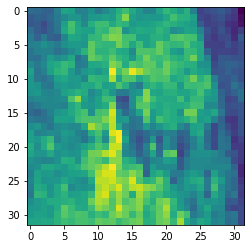

In [13]:
### How the image looks before feeding it to auto-encoder model
plt.imshow(X_train_copy[10])
plt.show()

In [14]:
### Auto-encoder model architecture
model = Sequential()
model.add(Conv2D(filters=3,kernel_size=3,padding='same',activation='relu',input_shape=(32,32,1), activity_regularizer=keras.regularizers.l1(10e-9)))
model.add(MaxPooling2D(pool_size = 2,padding='same'))
model.add(Conv2D(filters=1,kernel_size=3,padding='same',activation='relu', activity_regularizer=keras.regularizers.l1(10e-9)))
model.add(MaxPooling2D(pool_size = 2,padding='same',name='encoder_layer'))
model.add(Conv2D(filters=1,kernel_size=3,padding='same',activation='relu', activity_regularizer=keras.regularizers.l1(10e-9)))
model.add(UpSampling2D(2))
model.add(Conv2D(filters=3,kernel_size=3,padding='same',activation='relu', activity_regularizer=keras.regularizers.l1(10e-9)))
model.add(UpSampling2D(2))
model.add(Conv2D(filters=1,kernel_size=3,padding='same',activation='relu', activity_regularizer=keras.regularizers.l1(10e-9)))

In [15]:
### Compiling the model with optimizer as 'adam' and the loss value as 'mse'
model.compile(loss='mse', optimizer = 'adam')

In [16]:
### This will provide us with the complete architecture along with the number of parameters calculated and the image size at each layer
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 3)         30        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 1)         28        
_________________________________________________________________
encoder_layer (MaxPooling2D) (None, 8, 8, 1)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 1)           10        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 3)         3

In [17]:
### Fitting the autoencoder model on the dataset
model.fit(X_train_copy,X_train_copy, batch_size=32, epochs=5,verbose=2)

Epoch 1/5


2021-11-14 20:05:06.121642: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-14 20:05:06.121776: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


1563/1563 - 5s - loss: 0.0248
Epoch 2/5
1563/1563 - 4s - loss: 0.0110
Epoch 3/5
1563/1563 - 4s - loss: 0.0103
Epoch 4/5
1563/1563 - 4s - loss: 0.0100
Epoch 5/5
1563/1563 - 4s - loss: 0.0098


In [18]:
### Extracting the representation of the image from the 'encoder_layer'
encoder = Model(model.input, model.get_layer('encoder_layer').output)
encoded_data = encoder.predict(X_train_copy)

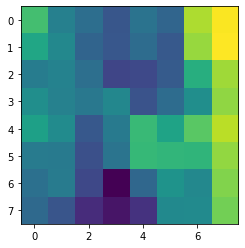

In [19]:
### How the image looks after extracting from encoded layer
plt.imshow(encoded_data[10])
plt.show()

<Figure size 432x288 with 0 Axes>

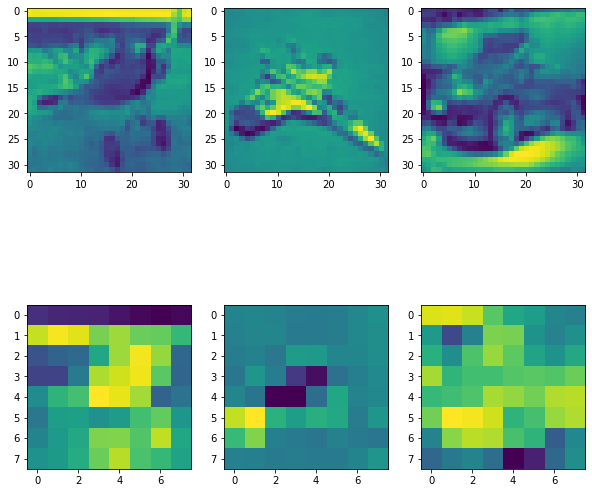

In [20]:
### Plotting the image before and after autoencoder's encoder layer
plt.figure()

f, axarr = plt.subplots(2,3,figsize=(10,10)) 
axarr[0][0].imshow(X_train_copy[35])
axarr[0][1].imshow(X_train_copy[30])
axarr[0][2].imshow(X_train_copy[45])
axarr[1][0].imshow(encoded_data[35])
axarr[1][1].imshow(encoded_data[30])
axarr[1][2].imshow(encoded_data[45])

In [21]:
### Converting the image size to feed it to kmeans clustering
X_train_auto_encoder = encoded_data.reshape(50000,-1)
X_train_auto_encoder.shape

(50000, 64)

In [22]:
### Running kmeans clustering on the features extracted from the encoded layer built in auto encoder model
kmean_auto = Kmeans(X_train_auto_encoder,y_train)
labels_auto = kmean_auto.fit()

Silhouette score:  0.076988675
Dunn index score:  0.034984842
